# Cinemática inversa

Dada la pose deseada para el efector final de un robot, ¿cómo deberán posicionarse sus articulaciones?

Supongamos que conocemos la pose de un objeto en coordenadas cartesianas y que este se encuentra dentro del rango de trabajo de un robot manipulador. ¿Cuáles deberán ser las configuraciones de los joints del robot para poder alcanzarlo? Este es el problema de la cinemática inversa, y en general, la solución no es única. Esto significa que el objeto podría alcanzarse mediante más de una combinación de configuraciones de los joints del robot.

In [68]:
# Importamos TODO el contenido de estos módulos en el namespace principal
# Esto nos posibilita invocar las clases y funciones directamente sin tener que usar `rtb.funcionMagica()`
# sino que podemos directamente hacer `funcionMagica()`, etc. Así nos queda muy similar a MATLAB
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import *

from math import pi

import numpy as np
import matplotlib.pyplot as plt

El siguiente ejemplo define un robot muy sencillo con 3 joints tipo rotacionales. Cada link mide 1 metro. Es muy similar al ejemplo del notebook anterior, sólo que con un link más. En este caso, definimos todo en una sola línea por brevedad:

In [4]:
R = DHRobot([DHLink(d=0, a=1, alpha=0), DHLink(d=0, a=1, alpha=0), DHLink(d=0, a=0.5, alpha=0), DHLink(d=0, a=0.5, alpha=0)])

Determinamos la posición deseada en x=2, y=0, z=0. Por simplicidad, en este ejemplo no se considerará la orientación, por lo que la sub-matriz de rotación será la matriz de identidad.

In [6]:
pose_deseada_1 = SE3.Trans(2, 0, 0)
print(pose_deseada_1)

   1         0         0         2         
   0         1         0         0         
   0         0         1         0         
   0         0         0         1         



Calculamos dos soluciones distintas utilizando "seeds" o semillas distintas, esto nos asegura que los resultados serán distintos.

In [8]:
sol1 = R.ikine_LM(pose_deseada_1, seed=0)
sol2 = R.ikine_LM(pose_deseada_1, seed=300)

A continuación, graficamos la representación del robot para las dos configuraciones de la cadena cinemática. En los gráficos se logra apreciar que el efector final se encuentra sobre la posición x=2, y=0, z=0 para ambos casos.

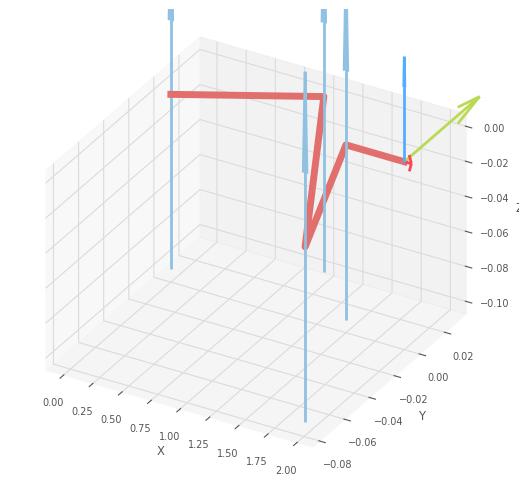

<Figure size 640x480 with 0 Axes>

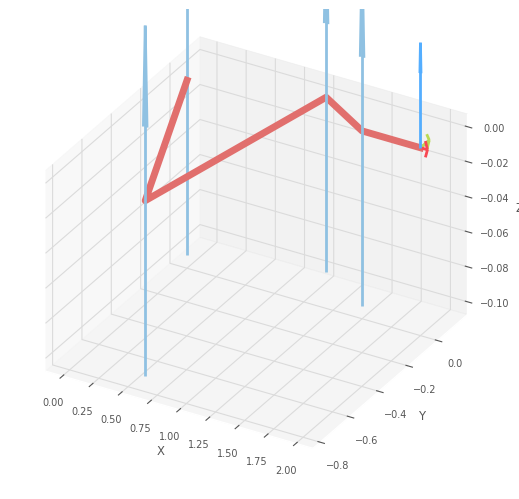

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, '')

<Figure size 640x480 with 0 Axes>

In [10]:
R.plot(sol1.q)
R.plot(sol2.q)

Dependiendo de la configuración del robot la pose deseada podría ser imposible de alcanzar. Algunos motivos que podrían explicar esta imposibilidad son:
- El robot no tiene suficientes grados de libertad para que su efector final adopte la pose deseada
- La pose se encuentran fuera del rango de trabajo del robot

Ante estos casos, podría ser necesario buscar una solución diferente, por ejemplo en algunos casos bastará con modificar ligeramente la orientación del efector final, incurriendo en un error algo mayor de lo ideal. El algoritmo de `ikine_LM` se encarga de calcular este error.

Para otros casos en que la posición u orientación no puedan calcularse, ni siquiera a costa de aumentar los márgenes de error, el algoritmo va a fallar y nos mostrará un mensaje específico.

In [12]:
pose_deseada_2 = SE3.Trans(2, 0, 0) * SE3.Rx(pi/4)

Aquí podemos ver claramente que la matriz de rotación ya no es la identidad, por lo que el efector final debería adoptar una rotación. Para el robot de nuestro ejemplo, esto es físicamente imposible, dado que nuestro efector final solo puede transladarse a lo largo del plano x=2, no puede rotar.

In [14]:
print(pose_deseada_2)

   1         0         0         2         
   0         0.7071   -0.7071    0         
   0         0.7071    0.7071    0         
   0         0         0         1         



In [15]:
sol3 = R.ikine_LM(pose_deseada_2)
print(sol3)

IKSolution: q=[0.5703, -1.781, 2.124, -0.9136], success=False, reason=iteration and search limit reached, iterations=3000, searches=100, residual=0.308


En el resultado de arriba podemos leer claramente lo siguiente: `success=False, reason=iteration and search limit reached`. Esto quiere decir que el resultado de la operación no pudo converger en un valor válido (es un algoritmo iterativo). Por lo que luego de 3000 iteraciones, la operación falló.

## Generación de trayectorias

A continuación vamos a hacer que el robot describa una trayectoria. La misma es generada a partir de dos poses, inicial y final, respectivamente.
Generamos la cinemática inversa para estas dos poses, lo que nos va a dar las configuraciones de los joints para la pose inicial, y para la pose final.

In [17]:
TE1 = SE3.Trans(0.4, -0.2, 0) * SE3.Rx(3);
TE2 = SE3.Trans(0.4, 0.2, 0) * SE3.Rx(1);

Utilizamos un modelo del robot PUMA 560 (representado por `models.DH.Puma560()`) para calcular las configuraciones articulares necesarias para alcanzar las poses `TE1` y `TE2`.

- `sol1` almacena la solución de la cinemática inversa para alcanzar la pose TE1. El método `ikine_a` resuelve la cinemática inversa con las opciones especificadas por "ru" (restricciones y opciones específicas para la resolución de la cinemática inversa).
- `sol2` almacena la solución de la cinemática inversa para alcanzar la pose TE2.

In [19]:
puma = models.DH.Puma560()
sol1 = puma.ikine_a(TE1, "ru")
sol2 = puma.ikine_a(TE2, "ru")

Creamos un vector de tiempo `t` que va desde 0 hasta 2 segundos en incrementos de 0.02 segundos. Este vector se utiliza para definir el tiempo de la trayectoria que el robot seguirá.

In [20]:
t = np.arange(0, 2, 0.02)

Generamos una trayectoria suave para el robot utilizando el método `jtraj` (trajectory generation function) que crea una interpolación entre las configuraciones articulares `sol1.q` y `sol2.q` a lo largo del tiempo definido por `t`.

- `sol1.q` representa las configuraciones articulares iniciales.
- `sol2.q` representa las configuraciones articulares finales.
`traj` es la trayectoria resultante que el robot seguirá desde `sol1.q` hasta `sol2.q` a lo largo del intervalo de tiempo `t`.

In [21]:
traj = jtraj(sol1.q, sol2.q, t)

En el gráfico de abajo se puede apreciar que el efector final describió una trayectoria entre las poses TE1 y TE2, yendo del punto y=-0.2 a y=0.2, mientras que x se mantuvo más o menos constante. Vale la pena mencionar que este método no garantiza que la trayectoria vaya a ser una línea recta.
Lo que se esta haciendo aquí es ir de una pose inicial a una pose final. Las poses intermedias van a depender del algoritmo de `jtraj`.

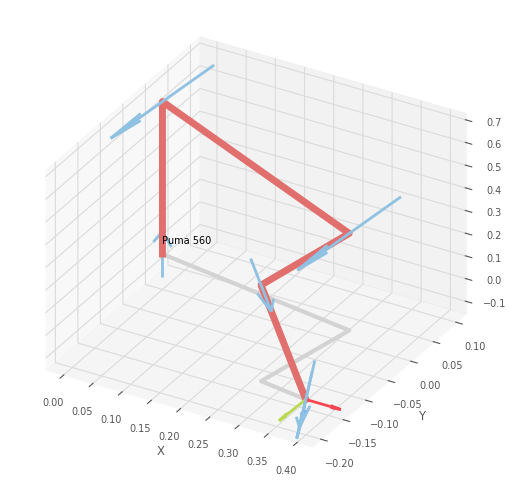

PyPlot3D backend, t = 4.99999999999999, scene:
  robot: Text(0.0, 0.0, 'Puma 560')

<Figure size 640x480 with 0 Axes>

In [60]:
# Este comando generará un archivo GIF animado que deberá aparecer en el árbol de archivos que tenemos a la izquierda.
# Tar da un rato en generarse. Una vez listo, se puede abrir haciendo doble click.
puma.plot(traj.q, movie="puma.gif")

Otra gráfica interesante es el estado de los joints a lo largo de la trayectoria, esto puede verse con el comando a continuación.

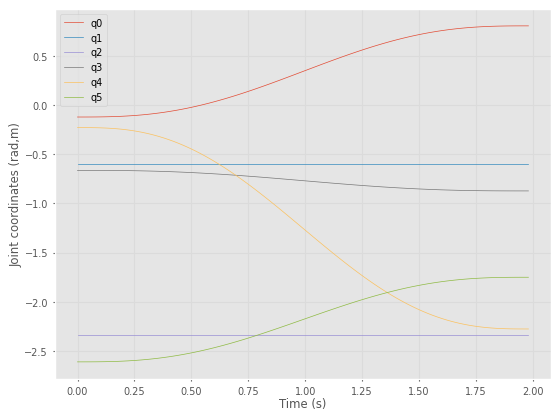

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [63]:
xplot(t, traj.q)

Aquí se aprecia cómo los joints `q0`, `q4` y `q5` fueron los que más variaron para representar la trayectoria, mientras que los demás permanecieron relativamente constantes. 